$$ \huge \text{Задача N тел в 2D Вселенной!} $$

In [19]:
%matplotlib inline

from abc import ABC, abstractmethod
import numpy as np
from numpy import array as vec
import numpy.linalg
import matplotlib.pyplot as plt
import itertools

MODEL_G = 0.7  # гравитационная постоянная
COLLISION_DISTANCE = 7.0
COLLISION_COEFFICIENT = 60.0
MODEL_DELTA_T = 0.001
TIME_TO_MODEL = 100

class Universe(ABC):
    
    def __init__(self):
        self.bodies = []

    @abstractmethod
    def gravity_flow_dencity_per_1_1(self, dist):
        """
        Плотность потока гравитационного поля между двумя
        единичными массами на заданном расстоянии
        """
        pass

    def model_step(self):
        for b1, b2 in itertools.product(self.bodies, self.bodies):
            if b1 != b2:
                b1.apply_force(b1.force_induced_by_other(b2))
        for b in self.bodies:
            b.advance()

    def add_body(self, body):
        self.bodies.append(body)


class MaterialPoint:
    """Материальная точка"""
    
    def __init__(self, universe, mass, position, velocity):
        self.universe = universe
        self.mass = mass
        self.position = position
        self.velocity = velocity
        universe.add_body(self)

        self.ptrace = [self.position.copy()]
        self.vtrace = [self.velocity.copy()]
    
    def force_induced_by_other(self, other):
        """Сила, с которой другое тело действует на данное"""
        delta_p = other.position - self.position
        distance = numpy.linalg.norm(delta_p)  # Евклидова норма (по теореме Пифагора)
        force_direction = delta_p / distance
        force = force_direction * self.mass * other.mass *\
                self.universe.gravity_flow_dencity_per_1_1(distance)
        return force

    def advance(self):
        """Перемещаем тело, исходя из его скорости"""
        self.position += self.velocity * MODEL_DELTA_T
        self.ptrace.append(self.position.copy())
        self.vtrace.append(self.velocity.copy())

    def apply_force(self, force):
        """Изменяем скорость, исходя из силы, действующей на тело"""
        self.velocity += force * MODEL_DELTA_T / self.mass

Осталось создать двухмерную Вселенную

In [20]:
class Universe2D(Universe):
    def __init__(self,
                 G,                  # гравитационная постоянная
                 k,                  # коэффициент при упругом соударении (отталкивание)
                 collision_distance  # дистанция соударения
                 ):
        super().__init__()
        self.G = G
        self.k = k
        self.collision_distance = collision_distance

    def gravity_flow_dencity_per_1_1(self, dist):
        if dist > self.collision_distance:
            # Притяжение по закону обратного расстояния
            return self.G / dist 
        else:
            # Отталкивание при соударении (антипритяжение с другим коэффициентом)
            return -self.k / dist 

Поместим парочку тел в нашу Вселенную и посмотрим, что получилось

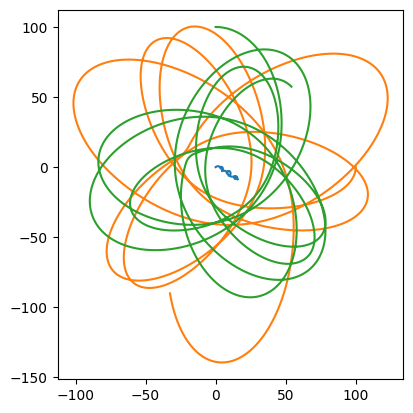

In [21]:
u = Universe2D(MODEL_G, COLLISION_COEFFICIENT, COLLISION_DISTANCE)

bodies = [
    MaterialPoint(u, 1000., vec([  0.,   0.]), vec([ 0.,   0.])),
    MaterialPoint(u,     10., vec([100.,   0.]), vec([ 0., -10.])),
    MaterialPoint(u,     10., vec([  0., 100.]), vec([15.,   0.]))
]
    
steps = int(TIME_TO_MODEL / MODEL_DELTA_T)
for stepn in range(steps):
    u.model_step()


plt.gca().set_aspect('equal')

for b in bodies:
    plt.plot(*tuple(map(list, zip(*b.ptrace))))

plt.show();

Заметим, что траектории тел могут напоминать движение маятника Фуко, но я думаю это чудесное совпадение (сильно зависит от выбранного $ MODEL\_G $). Так же видно, что центральное тело $ \textbf{("Звезда")} $ имеет небольшое смещение относительно первоначального положения, причем в обе строны вдоль прямой.

Полученная картинка подтверждает, что первоначальное предположение Кеплера о том, что тела взаимодействуют по закону обратного радиуса в первой степени - $ \underline{\text{ошибочно}}$: планеты бы давно с ума посходили, двигаясь по таким орбитам.

Вернемся к нашему миру - 3D Вселенной

In [22]:
MODEL_G = 0.5 
COLLISION_DISTANCE = 5.0
COLLISION_COEFFICIENT = 50.0
MODEL_DELTA_T = 0.01
TIME_TO_MODEL = 100

class Universe3D(Universe):
    def __init__(self,
                 G,                  # гравитационная постоянная
                 k,                  # коэффициент при упругом соударении
                 collision_distance  # всё-таки это не точки
                 ):
        super().__init__()
        self.G = G
        self.k = k
        self.collision_distance = collision_distance

    def gravity_flow_dencity_per_1_1(self, dist):
        if dist > self.collision_distance:
            return self.G / dist ** 2
        else:
            return -self.k / dist ** 2

u = Universe3D(MODEL_G, COLLISION_COEFFICIENT, COLLISION_DISTANCE)

bodies = [
    MaterialPoint(u, 50000., vec([  0.,   0.]), vec([ 0.,   0.])),
    MaterialPoint(u,     10., vec([100.,   0.]), vec([ 0., -10.])),
    MaterialPoint(u,     10., vec([  0., 100.]), vec([15.,   0.]))
]
    
steps = int(TIME_TO_MODEL / MODEL_DELTA_T)
for stepn in range(steps):
    u.model_step()

 Проверим выполнение $ \textit{2 закона Кеплера!} $

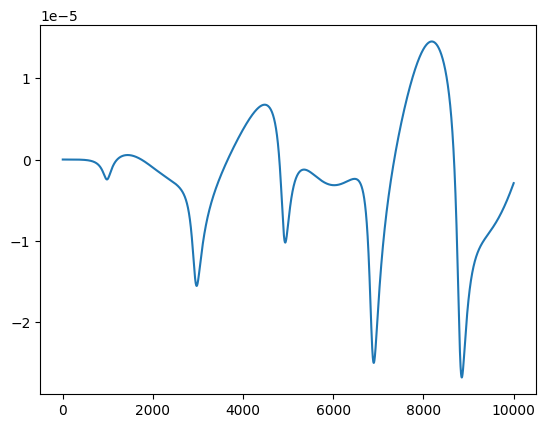

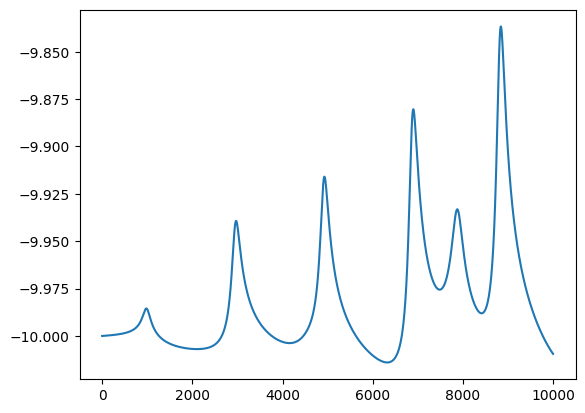

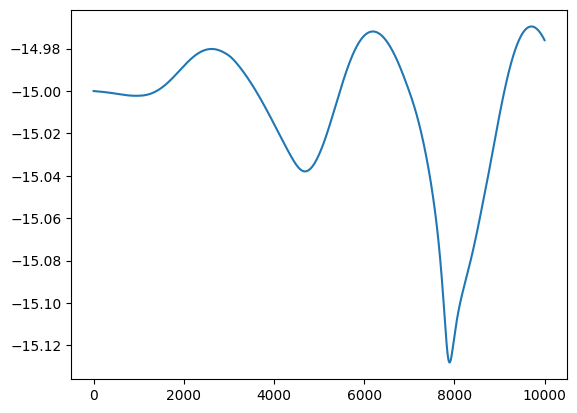

In [25]:
def plt_kepler(same_fig = False):
    for b in bodies:
        plt.plot([
            numpy.cross(pos, vel * MODEL_DELTA_T)
            for pos, vel in zip(b.ptrace, b.vtrace)
        ])

        if not same_fig: # По картинке на тело
            plt.show()
    if same_fig: # Одна картинка на всех
        plt.show()

plt_kepler() # Вывод на разных графиках

Заметим, что значения отличаются очень слабо, но для пущего эффекта стоит изобразить все на одном графике

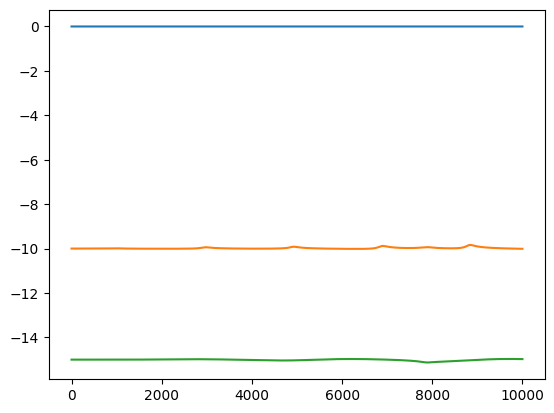

In [26]:
plt_kepler(True)

Как видно, отклонений почти нет, значит, 2 закон Кеплера действительно $ \textbf{справедлив} $.
